# Natural Language Processing Challenge
### By Vinicius Rogério da Silva
[LinkedIn](https://www.linkedin.com/in/viniciusrogerio/) | [RPubs](https://rpubs.com/viniciusrogerio) | [GitHub](https://github.com/viniciusrogerio)

---

# Introduction

The field of NLP - Natural Language Processing is a part of AI dedicated to understanding text data and deriving patterns and useful information from it. One of the tasks associated with NLP is the classification of documents (texts), where algorithms are trained to automatically identify the category of the texts according to their content. This can be done both using supervised learning techniques (such as in this challenge), where there is labeled data available, or unsupervised learning, where labels do not exist in the first place.

In this challenge, a dataset containing information about scientific articles in the field of Astrophysics is given. The first goal is to predict which subjects are related to each article, and as we can see further, this is a multilabel problem, since each article can be associated to multiple subjects.

Finally, the ultimate goal is to predict the number of articles for each subject in each month of the test set.

In [214]:
# Loading dependencies
from google.colab import drive
import pandas as pd
# from wordcloud import WordCloud
import ast
import numpy as np
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.neural_network import MLPClassifier

import re

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mounting Drive
# drive.mount('/content/drive')

Mounted at /content/drive


# EDA and data preparation

In this section, we first read the data and take a look at the variables. 

In [ ]:
# Reading Train Data
path = r"/<...>"
train_data = pd.read_csv(path+'Train_Data.csv')
train_data = pd.DataFrame(train_data)
train_data.head(n=10)

,Title,Date,Abstract,Subjects
0,The Neutrino Ball Model of a Quasar,1993-04-07,It is suggested that the nonorthodox model o...,['Astrophysics']
1,Charged Boson Stars and Vacuum Instabilities,1993-05-12,We consider charged boson stars and study th...,"['Astrophysics', 'General Relativity and Quant..."
2,Pre-main sequence lithium burning. I. Weak T T...,1993-08-31,We derive lithium abundances in 53 T Tauri s...,['Astrophysics']
3,Very High Energy Gamma-Rays from AGN: Cascadin...,1993-12-18,Recent high energy gamma-ray observations (E...,['Astrophysics']
4,From the Owl to the Eskimo: the Radiation-Gasd...,1994-04-29,We present the results of two-dimensional ra...,['Astrophysics']
5,Galaxy Mergers and Gravitational Lens Statistics,1994-05-05,We investigate the impact of hierarchical ga...,['Astrophysics']
6,The R Axion From Dynamical Supersymmetry Breaking,1994-05-20,"All generic, calculable models of dynamical ...","['High Energy Physics - Phenomenology', 'Astro..."
7,Ubc/Laval 2.7-Meter Liquid Mirror Telescope,1994-06-21,We report the successful development and ope...,['Astrophysics']
8,About the Malmquist bias in the determination ...,1994-07-26,We provide the mathematical framework which ...,['Astrophysics']
9,The Theory of Everything vs the Theory of Anyt...,1994-08-18,To what extent can our limited set of observ...,"['General Relativity and Quantum Cosmology', '..."


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29191 entries, 0 to 29190
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     29191 non-null  object
 1   Date      29191 non-null  object
 2   Abstract  29191 non-null  object
 3   Subjects  29191 non-null  object
dtypes: object(4)
memory usage: 912.3+ KB


### A first look at the train data

There are 29191 observations and 4 variables: Title of the article, Date of publication, Abstract and a list of Subjects related to the article.

**It seems that the data that is going to be useful for modeling purposes is contained in both title and abstract of the article.** We will put them together later on.

In [7]:
train_data.Subjects.unique()

array(["['Astrophysics']",
       "['Astrophysics', 'General Relativity and Quantum Cosmology']",
       "['High Energy Physics - Phenomenology', 'Astrophysics', 'High Energy Physics - Theory']",
       ...,
       "['Astrophysics - Cosmology and Nongalactic Astrophysics', 'Astrophysics - Instrumentation and Methods for Astrophysics', 'Computer Science - Machine Learning']",
       "['Physics - Instrumentation and Detectors', 'Astrophysics - Earth and Planetary Astrophysics', 'Astrophysics - Instrumentation and Methods for Astrophysics']",
       "['Nuclear Theory', 'Astrophysics - High Energy Astrophysical Phenomena', 'Quantum Physics']"],
      dtype=object)

As said before, we see above that one single article can be associated to multiple subjects. It will be needed to transform the subject variable so we can work with it in the modeling stage.

In [8]:
# Creating lists of all subjects
all_subjects = []
count_subjects = []
subjects_lists = []

for sub in train_data.Subjects:
  item = ast.literal_eval(sub)
  subjects_lists.append(item)
  count_subjects.append(len(item))
  for subsub in item:
    all_subjects.append(subsub)

In [9]:
all_subjects = np.array(all_subjects)
unique_subjects = np.unique(all_subjects)
train_data["Subjects"] = pd.Series(subjects_lists)

print("Count of total possible subjects: ",len(unique_subjects))
print("Max number of subjects assigned to a single article: ",max(count_subjects))
#type(train_data.Subjects)


Count of total possible subjects:  111
Max number of subjects assigned to a single article:  7


We have 111 possible subjects in total, and the max number of subjects assigned to a single article is 7.

In [ ]:
def count_subjects(unq_sub):

  subject_counts = []

  # Counting occurrences of each subject
  for subject in unq_sub:
    subject_count = 0
    for index, row in train_data.iterrows():
      if subject in row['Subjects']:
        subject_count = subject_count + 1
    current_count = (subject,subject_count)
    subject_counts.append(current_count)

  return dict(subject_counts)

subject_counts = count_subjects(unique_subjects)

In [11]:
# Keeping only subjects with at least 50 occurrences
# for the sake of visualization

def plot_occurrences(d,min,max):
  if max == None:
    dict_graph = {k:v for (k,v) in d.items() if v >= min}
  else:
    dict_graph = {k:v for (k,v) in d.items() if v >= min and v <= max}

  names = list(dict_graph.keys())
  values = list(dict_graph.values())

  plt.barh(range(len(dict_graph)), sorted(values), tick_label=names)
  plt.show()


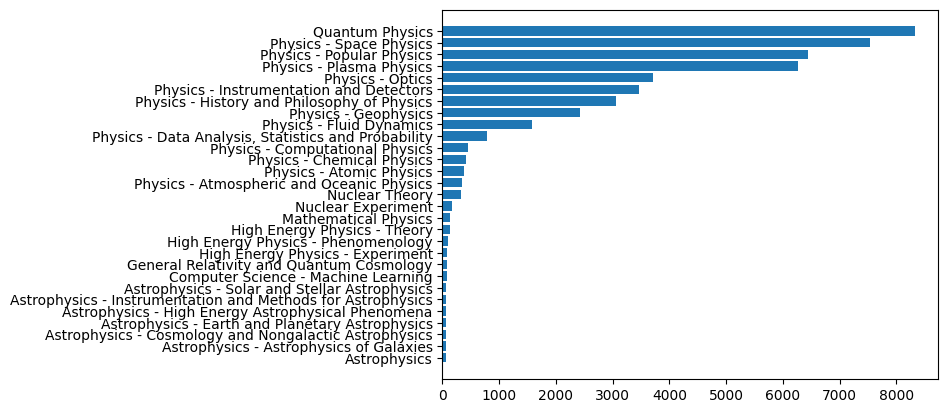

In [12]:
plot_occurrences(subject_counts,50,None)

The graph above represents the total occurrences for subjects with at least 50 occurrences among all the articles. **We can see that articles on the Physics field appear the most.**

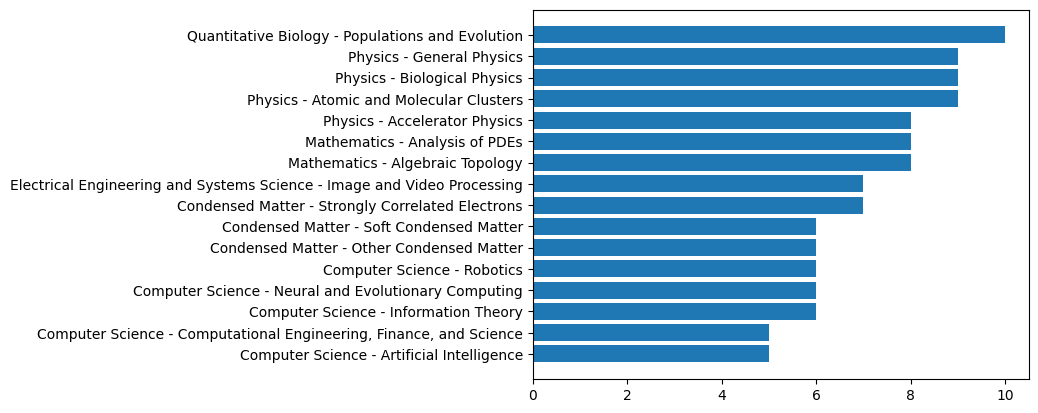

In [13]:
plot_occurrences(subject_counts,5,10)

Above we can also see the subjects that have only from 5 to 10 occurrences, and there is no predominant field among them.

In [14]:
dict_one = {k:v for (k,v) in subject_counts.items() if v == 1}
dict_one

{'Astronomy and Astrophysics': 1,
 'Astrophysics of Galaxies (astro-ph.GA), Cosmology and Nongalactic\\n  Astrophysics (astro-ph.CO)': 1,
 'Computer Science - Computation and Language': 1,
 'Computer Science - Discrete Mathematics': 1,
 'Computer Science - Multimedia': 1,
 'Computer Science - Networking and Internet Architecture': 1,
 'Computer Science - Operating Systems': 1,
 'Computer Science - Other Computer Science': 1,
 'Computer Science - Programming Languages': 1,
 'Computer Science - Sound': 1,
 'Computer Science - Symbolic Computation': 1,
 'Electrical Engineering and Systems Science - Audio and Speech Processing': 1,
 'Mathematics - Algebraic Geometry': 1,
 'Mathematics - Geometric Topology': 1,
 'Mathematics - History and Overview': 1,
 'Mathematics - Logic': 1,
 'Mathematics - Symplectic Geometry': 1,
 'Quantitative Biology - Biomolecules': 1,
 'Quantitative Biology - Neurons and Cognition': 1,
 'Quantitative Finance - Statistical Finance': 1,
 'Statistics - Other Statisti

And finally, the above subjects appeared only once. This might play an important role in the modeling stage, as stated in the conclusion.

### Preprocessing the data

In order to apply NLP techniques, we must have in mind that the original data comes with unwanted patterns. Line breaks, excessive whitespace, symbols and all kinds of special characters might lead to errors or biases in the model estimation. So the first step of preprocessing is **cleaning the texts** so all of that unwanted stuff is removed.

I'm going to treat the text information as one whole thing. So the Title and the Abstract of the articles are going to be concatenated.

Function defined below performs both of these steps.

In [ ]:
# Function to clean the texts
def get_full_text(data):

  full_texts = []

  for index, row in data.iterrows():
    text = row.Title + ' ' + row.Abstract
    text = text.lower()

    # Removing linebreaks (and eventual \n that persisted)
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\n", " ", text)

    # Removing numbers, symbols, special characters and punctuation
    text = re.sub(r"[\W\d_]+", " ", text)

    full_texts.append(text)

  return full_texts

full_texts = get_full_text(train_data)

#### Removing Stopwords

After cleaning the texts and also joining Title and Abstract, another step of preparation is removing stopwords. Stopwords, basically speaking, are words that might not give useful information about the text, and might introduce some "noise" in the whole process. Every language has it's own set of stopwords, but in american english some examples are "a", "be", "but", "for", "how", "is", "in", "my", "or"... and many others.

To remove all the stopwords from the texts, I've taken advantage of the NLTK package, which has a standard set of stopwords. I've also appended the letter "n" to the set of stopwords, because many abstracts appeared to have this letter isolated in their content.

In [ ]:
nltk.download("stopwords")

# Function to remove stopwords
def remove_stopwords(txts):
  sw = stopwords.words("english")
  sw.append('n')

  full_texts2 = []

  for text in txts:
    text = [word for word in text.split() if word not in sw]
    text = " ".join(text)
    full_texts2.append(text)

  return full_texts2

full_texts2 = remove_stopwords(full_texts)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
full_texts2[0:3]

['neutrino ball model quasar suggested nonorthodox model quasar neutrino ball described terms standard model extended adding right handed neutrinos majorana scalar field presented order explain quasar body weak interacting neutrinos neutrino interaction scalar majorana field violates lepton number produces mass splitting neutrino due sea saw mechanism model quasar object appears result first order cosmological phase transition interpretation quasar may regarded ball filled dirac neutrinos treated remnant phase transition unbroken global lepton symmetry paper study macroscopic parameters configuration result mass radius curve r quasar obtained',
 'charged boson stars vacuum instabilities consider charged boson stars study effect structure vacuum compact particle like stars constituent mass close planck mass pl e cal alpha pl argue limiting total electric charge z c primarily due formation pion condensate z c simeq alpha e alpha fine structure constant e electric charge positron charge s

The above output gives us an idea of the resulting texts after the stopwords are removed.

#### Lemmatization

Another step of preprocessing text data in NLP is called lemmatization. It consists of transforming each word to its "root" form, called a lemma. For example: 

* lemmatize("giving") = "give"
* lemmatize("gave") = "give"
* lemmatize("gives") = "give"
* lemmatize("given") = "give"

and so on. All these words might mean different things in their own context, but for an NLP model they might carry the same information, and so should be treated as one single thing. This process commonly increases performance in the context of text classification. The spaCy package is being use to perform lemmatization, as the code below shows.


In [18]:
spc = spacy.load('en_core_web_sm', disable = ['parser','ner'])
full_texts_final = []

docs = [spc(txt) for txt in full_texts2]

full_texts_final = [str(x) for x in docs]

#### Feature Extraction

Once we have our text clean, with no stopwords and lemmatized, we now must transform it in a way that can be understood by the algorithms. This process is known as Feature Extraction, and many different methods can be applied to transform text into numeric vectors that will serve as an input to the models.

One of the most common techniques is the BagOfWords (BoW), where words are represented by how many times they occur, or by 1's and 0's indicating whether they occur or not (binary approach). The problem with this technique is it doesn't take into account the relevance of that word in the context of the given texts.

To overcome that issue, another well-known technique is TF-IDF, which stands for Term Frequency - Inverse Document Frequency. The Term Frequency, as the name suggests, measures the frequency of occurrence of the word in the document, while the Inverse Document Frequency measures how "rare" a word is in the whole set of documents (in our case, all titles + subjects). By doing that, TF-IDF gives a weight to each word, that represents how important that word is in the context.

For these reasons, TF-IDF is the technique that has been chose here.

In [19]:
vector = TfidfVectorizer(max_features=19000)
X = vector.fit_transform(full_texts_final)

The max number of features has been set to 19000 because there are about 19K different words on the test set (that is the size of the vocabulary). So I've set this value for the train data as well, since the vector of features of both train and test data must have the same number of columns.

In [20]:
print(type(X))
print(X.get_shape())

<class 'scipy.sparse._csr.csr_matrix'>
(29191, 19000)


In [21]:
pd.DataFrame(X.toarray())

,0,1,2,3,4,5,6,7,8,9,...,18990,18991,18992,18993,18994,18995,18996,18997,18998,18999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is how our final features look like: 19000 columns with weighted values for words (many of them will be 0).

# Modeling

In this section I'm going to adjust classification models for the given problem. I also give a quick explanation about the functioning of each model, but without going into the depths of maths and statistics behind them.

#### Transforming the target variable

In the same way that we transformed our features, it's also needed to transform our target variable.

As said before, this is a multilabel (multi-target) classification problem, since each article can be assigned to multiple subjects. That being said, since we have 111 possible articles, each of them will be represented by one target variable (y1,...,y111).

The MultiLabelBinarizer have been used to perform that transformation:

In [22]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_data.Subjects)

In [23]:
pd.DataFrame(y)

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29186,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
29187,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29188,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29189,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Later on, these targets will be handled by classifiers that support multiple outputs.

#### Creating train and validation sets

Since the test data has been provided separately and no labels have been included in it, I'll split the train data into train and validation subsets. This way of working is closer to a real life application, where our test data probably won't come labeled in most cases. So the performance of our models should be assessed in the validation set. A seed is also set for the sake of reproductability.

In [24]:
seed = 1
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = 0.3,
                                                    random_state = seed)

### Description of the models

#### Decision Trees

Decision trees are widely used in the context of classification tasks. They consist of a top-down structure of nodes and leaves, where each node represents a logical test. After passing through all nodes, the result (leaf) is the target label assigned to the given observation.

There are basically 3 main algorithms used to generate decision trees: ID3, CART and C4.5. The implementation found in scikit-learn is an adaptation of the CART algorithm.

#### Random Forests

Random Forests are, basically speaking, ensembles of decision trees. This means that they gather a large number of decision trees and combine their output to give a final classification. This process takes place in a way that each tree of the ensemble is trained on a random subset of the original features, so the given result is more reliable than the one given by a single tree.


#### MLPClassifier

The MLPClassifier is a classifier based on Multi-layer Perceptrons. The latter is a type of artificial neural network that have multiple hidden layers, and their architecture can be configured by the user, so the number of hidden layers and neurons on each layer will affect directly the outcome. The configuration used in the context of this challenge was a simple one.

#### Use of MultiOutputClassifier

The MultiOutputClassifier (MOC) is useful when we have a classifier that does not support multilabel tasks natively. Given a dataset containing multiple labels, the MOC will treat each one of them as a separate binary classification task, and then will be able to predict all the labels simultaneously.

In this challenge, MOC have been used even for algorithms that suport multi-output natively, in order to facilitate the code implementation.

### Evaluation Metrics

In the context of classification tasks, some metrics are useful to measure how well the model is predicting for unseen data. Four of them are the most common ones:

* Accuracy: measures the proportion of observations that have been correctly classified by the model in general;
* Precision: proportion of the observations predicted positive that are actually positive. That is: how much our model is right when it states that one observation is from a certain class;
* Recall: proportion of the observations that are positive in reality that were captured by the model as positive. That is: how "sensible" our model is to a certain given class;
* F1-score: the harmonic mean between Precision and Recall.

The accuracy itself might not always be the right metric to look at, as it doesn't take the difference between classes into consideration. That's why it's recommended to evaluate these other metrics as well.

The function below has been defined to calculate the described metrics for each model.

In [218]:
# Function to evaluate model metrics
def evaluate(y_true, y_pred):
  print("accuracy: ", round(accuracy_score(y_true, y_pred),4))
  print("\nprecision: ", round(precision_score(y_true, y_pred, average='weighted'),4))
  print("\nrecall: ", round(recall_score(y_true, y_pred, average='weighted'),4))
  print("\nf1-score: ", round(f1_score(y_true, y_pred, average='weighted'),4))

### Fiting the models

In this subsection, models are fitted using the techniques described earlier.

In [26]:
moc0 = MultiOutputClassifier(DecisionTreeClassifier(random_state = seed)).fit(X_train, y_train)

In [212]:
moc1 = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state = seed)).fit(X_train, y_train)

In [ ]:
# moc2 = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=seed)).fit(X_train, y_train)

In [213]:
moc3 = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(8,8), random_state = seed)).fit(X_train, y_train)

# Model Evaluation and Selection

### Computing metrics

Now that we have adjusted our models, we can get their evaluation metrics.

In [219]:
pred0 = moc0.predict(X_eval)
pred1 = moc1.predict(X_eval)
pred3 = moc3.predict(X_eval)

In [220]:
print("Decision Tree: \n")
evaluate(y_eval,pred0)

print("\nRandom Forest: \n")
evaluate(y_eval,pred1)

print("\nMLPClassifier: \n")
evaluate(y_eval,pred3)

Decision Tree: 

accuracy:  0.3021

precision:  0.6172

recall:  0.6135

f1-score:  0.615

Random Forest: 

accuracy:  0.4768

precision:  0.8367

recall:  0.5393

f1-score:  0.6356

MLPClassifier: 

accuracy:  0.4691

precision:  0.7467

recall:  0.6837

f1-score:  0.7076


As we can see, the model that gives us the best estimated accuracy is the Random Forest, while the best estimated F1-Score is observed at the MLPClassifier.

Taking this into account, MLPClassifier will be the selected model for predicting the labels on our Test Data, since F1-score gives a better balance between precision and recall.

# Predicting for the Test Data


### Preprocessing

First of all, we need to read the test data and preprocess it, similarly to what has been done with the train data. All the steps are gonna be executed at once, since they have already been explained separately earlier.

In [221]:
# Reading test data
test_data = pd.DataFrame(pd.read_csv(path+"Test_Data.csv"))

# Cleaning and removing stopwords from test data
test_full_texts = get_full_text(test_data)
test_full_texts2 = remove_stopwords(test_full_texts)

# Lemmatizing test data
spc = spacy.load('en_core_web_sm', disable = ['parser','ner'])
test_full_texts_final = []
docs = [spc(txt) for txt in test_full_texts2]
test_full_texts_final = [str(x) for x in docs]

# Applying TF-IDF vectorization
X_test = vector.fit_transform(test_full_texts_final)

### Predicting

Now we can use the selected model to make predictions based on the features contained in the test set.

In [222]:
pred_final = moc3.predict(X_test)

In [223]:
pred_final = pd.DataFrame(pred_final)

In [224]:
# Saving our final predictions
pred_final.to_csv("pred_final.csv")

### Summarizing data by subject and month

Since the desired output is the count of Subjects by Month, I'm going to perform some transformations on the predicted dataset.

In [232]:
# Reading predictions
predicted = pd.read_csv("/content/pred_final.csv")

In [233]:
predicted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7370 entries, 0 to 7369
Columns: 112 entries, Unnamed: 0 to 110
dtypes: int64(112)
memory usage: 6.3 MB


In [234]:
predicted.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [235]:
final_df = pd.concat([test_data,predicted],axis=1)
final_df = final_df.drop(['Unnamed: 0','Title','Abstract'],axis=1)

In [236]:
final_df.head()

,Date,0,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,2019-05-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-05-01,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-05-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-05-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-05-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
# Transforming type of date
final_df.Date = pd.to_datetime(final_df.Date)
grouped_df = final_df.groupby(pd.Grouper(key='Date', freq='1M')).sum()
grouped_df = pd.DataFrame(grouped_df)
grouped_df.reset_index(inplace=True)
grouped_df["Date"] = grouped_df["Date"].dt.to_period('M')

In [238]:
grouped_df

,Date,0,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,2019-05,0,1,38,38,21,56,105,55,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-06,0,4,31,35,23,54,94,49,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-07,0,1,42,34,31,59,97,60,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-08,0,0,42,35,34,60,104,51,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-09,0,3,50,42,35,60,111,57,0,...,0,0,0,0,0,0,0,0,0,0
5,2019-10,0,0,10,9,8,7,32,16,0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
# Creating list of indexes
a = list(range(0,111))
indexes = [str(x) for x in a]

In [240]:
result = pd.melt(grouped_df, id_vars =['Date'], value_vars=indexes)
result = result.rename(columns={"Date": "Month", "variable": "Sub", "value":"Count"})

In [241]:
result

,Month,Sub,Count
0,2019-05,0,0
1,2019-06,0,0
2,2019-07,0,0
3,2019-08,0,0
4,2019-09,0,0
...,...,...,...
661,2019-06,110,0
662,2019-07,110,0
663,2019-08,110,0
664,2019-09,110,0


The dataset above still needs to be assigned to the original subjects.

In [244]:
dictlist = []
i=0
for orig_sub in mlb.classes_:
  dictlist.append([i,orig_sub])
  i+=1

In [245]:
mapping = pd.DataFrame(dictlist)
mapping = mapping.rename(columns={0: "Sub", 1: "Subject"})
mapping.Sub = mapping.Sub.astype(str)

In [276]:
new_df = pd.merge(result, mapping, on=["Sub"])
new_df = new_df.drop("Sub",axis=1)
cols = ['Month','Subject','Count']
new_df = new_df[cols].sort_values(by=["Month","Subject"],ascending=True)
new_df

,Month,Subject,Count
0,2019-05,Astronomy and Astrophysics,0
6,2019-05,Astrophysics,1
12,2019-05,Astrophysics - Astrophysics of Galaxies,38
18,2019-05,Astrophysics - Cosmology and Nongalactic Astro...,38
24,2019-05,Astrophysics - Earth and Planetary Astrophysics,21
...,...,...,...
641,2019-10,Statistics - Applications,0
647,2019-10,Statistics - Computation,0
653,2019-10,Statistics - Machine Learning,0
659,2019-10,Statistics - Methodology,0


In [277]:
new_month = ['May - 19' if '05' in month
             else 'Jun - 19' if '06' in month
             else 'Jul - 19' if '07' in month
             else 'Aug - 19' if '08' in month
             else 'Sept - 19' if '09' in month
             else 'Oct - 19'
             for month in list(new_df.Month.astype(str))]

In [278]:
new_df["Month"] = new_month

In [279]:
new_df

,Month,Subject,Count
0,May - 19,Astronomy and Astrophysics,0
6,May - 19,Astrophysics,1
12,May - 19,Astrophysics - Astrophysics of Galaxies,38
18,May - 19,Astrophysics - Cosmology and Nongalactic Astro...,38
24,May - 19,Astrophysics - Earth and Planetary Astrophysics,21
...,...,...,...
641,Oct - 19,Statistics - Applications,0
647,Oct - 19,Statistics - Computation,0
653,Oct - 19,Statistics - Machine Learning,0
659,Oct - 19,Statistics - Methodology,0


After performing all of these transformations, we can finally export the Submit file.

In [280]:
new_df.to_csv("Submit.csv",index=False)

# Conclusion

After going through all the modeling process, we were able to select a model to predict the number of articles on each subject by months of the Test Data.

Altough our performance metrics might not be the best possible, this model can be a starting point for that task.

### The answer to the proposed questions follow:

* I've first tried using Decision Trees, because they have proven to be good algorithms for generating models for classification tasks, and are largely used. Same reason came for using Random Forests, because since they're ensambles of Decision Trees, their combination can lead to enhanced performance. Finally, using MLPClassifier was a choice based in my computational limitations, since other ANN-based models are more complex to adjust and tend to take a lot more time and resources. Despite that, it was interesting to have classical ML compared to a Deep Learning approach.

* Since no original labels have been given in Test_Data, the performance of the models had to be assessed through an evaluation subset. This is a common practice in real life applications, where non-labeled data is the input of a model in production. The metrics used to measure the performance have been accuracy, precision, recall and f1-score.

* If I had only another day, I would try fitting other ANN-based models, or even adjust an MLPClassifier using a higher number of layers and nodes for each layer. This would probably take many hours to run, but maybe could increase performance.

* If I had another week, I would do the same as described before, plus a deeper literature review on the subject. I would also study, compare and test multiple combinations of hyperparameters for the models, affecting their performance in better depth. Beyond that, it would be interesting to test different architechtures of ANNs and see how they would affect performance in this particular problem. I would also try to fit a Logistic Regression model, since I had no success when I tried to do so, because some of the subjects have only a single occurrence in the whole Train_Data. It could also be nice to better analyse both stopword removal and lemmatization processes, since they have been performed in their most standard form. Finally, I would also perform some code refactoring, since I'm aware that my code is not in the ideal form in terms of readability and maintenance, and this notebook could also be more readable.

* The estimated score for the MLPClassifier model was an f1-score of 0.7076. It's also worth pointing out that the overall accuracy of this model was 0.4691, outperforming the Decision Tree, but staying at about the same level of the Random Forest. Maybe some better parametrization of the Random Forest could even be able to outperform the MLPClassifier in all the metrics, but I couldn't get that done on time.

Please feel free to contact me.

[LinkedIn](https://www.linkedin.com/in/viniciusrogerio/) | [RPubs](https://rpubs.com/viniciusrogerio) | [GitHub](https://github.com/viniciusrogerio)